# Catastrophic forgetting example over 4 tasks

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import models as models

Adapted from Original Pytorch github https://github.com/pytorch/examples/blob/main/mnist/main.py 

In [2]:
def auto_remap_target(target, class_list):
    """
    Automatically remap target values to the range [0, num_classes-1].

    Args:
    - target (torch.Tensor): Target tensor with original class indices.
    - class_list (list): List of class indices in your classification task.

    Returns:
    - torch.Tensor: Remapped target tensor.
    """
    remap_dict = {class_val: idx for idx, class_val in enumerate(class_list)}
    remapped_target = torch.tensor([remap_dict[val.item()] for val in target])
    return remapped_target

def inverse_remap_target(remapped_target, class_list):
    """
    Map remapped target values back to their original values.

    Args:
    - remapped_target (torch.Tensor): Remapped target tensor.
    - class_list (list): List of class indices in your classification task.

    Returns:
    - torch.Tensor: Original target tensor.
    """
    original_target = torch.tensor([class_list[idx] for idx in remapped_target])
    return original_target



def train(args, model, device, train_loader, optimizer, epoch, label_types=[0, 1, 2, 3, 4, 5]):
    """
    Train the neural network model using negative log-likelihood loss for multi classification.

    Args:
    - args: Commacnd-line arguments and configurations.
    - model: The neural network model to be trained.
    - device: The device to which data and model should be moved (e.g., "cuda" for GPU or "cpu").
    - train_loader: DataLoader providing training data.
    - optimizer: Optimizer for updating model parameters.
    - epoch: The current epoch number.
    - label_types: unique labels per task

    Returns:
    - accuracy: Accuracy of the model on the training set.
    - average_loss: Average binary cross-entropy loss over the training set.
    """
    model.train()
    total_loss = 0.0
    correct = 0
    

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        remapped_target = auto_remap_target(target, label_types)
        #loss = F.nll_loss(output, remapped_target, reduction='sum').item()
        
        loss = F.nll_loss(output, remapped_target)
        #loss = F.nll_loss(output, target)
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        pred = inverse_remap_target(pred, label_types)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss.backward()
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

    # Calculate and return the average loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100.*correct / len(train_loader.dataset)
    return accuracy, average_loss

def validate(model, device, dataloader, label_types=[0, 1, 2, 3, 4, 5]):
    """
    Evaluate the neural network model on a validation or test set using binary cross-entropy loss for binary classification.

    Args:
    - model: The neural network model to be evaluated.
    - device: The device to which data and model should be moved (e.g., "cuda" for GPU or "cpu").
    - test_loader: DataLoader providing validation or test data.

    Returns:
    - accuracy: Accuracy of the model on the validation or test set.
    - val_loss: Binary cross-entropy loss on the validation or test set.
    - all_predictions: Predicted labels for all instances in the validation or test set.
    - all_labels: True labels for all instances in the validation or test set.
    """
    model.eval()
    val_loss = 0
    correct = 0
    
    all_predictions = []
    all_labels = []

    
    with torch.no_grad():
            for data, target in dataloader:
                
                data, target = data.to(device), target.to(device)
                output = model(data)
        
                remapped_target = auto_remap_target(target, label_types)
                val_loss = F.nll_loss(output, remapped_target, reduction='sum').item()
                pred = output.argmax(dim=1)  # get the index of the max log-probability
                pred = inverse_remap_target(pred, label_types)
                correct += pred.eq(target.view_as(pred)).sum().item()
                all_predictions.append(pred.cpu().numpy())
                all_labels.append(target.cpu().numpy())
    
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions).squeeze(0)
    all_labels = np.array(all_labels).squeeze(0)
    
    val_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    print('\Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(dataloader.dataset),
        100. * correct / len(dataloader.dataset)))
    
    return accuracy, val_loss, all_predictions, all_labels
    
  
def train_and_validate(args, 
                       model, 
                       device, 
                       train_loader, 
                       val_loader, 
                       optimizer, 
                       scheduler, 
                       title = "", 
                       type_label=[0, 1, 2, 3, 4, 5],
                       model_path= "model.pt"):
    """
    Train and validate a neural network model across multiple epochs.

    Args:
    - args: Command-line arguments and configurations.
    - model: The neural network model to be trained and validated.
    - device: The device to which data and model should be moved (e.g., "cuda" for GPU or "cpu").
    - train_loader: DataLoader providing training data.
    - val_loader: DataLoader providing validation or test data.
    - optimizer: Optimizer for updating model parameters.
    - scheduler: Learning rate scheduler.
    - title: Title for the plot (optional).
    - model_path: path to store the model

    Returns:
    - all_predictions: Predicted labels for all instances in the validation or test set.
    - all_labels: True labels for all instances in the validation or test set.
    """
    train_losses = [] 
    train_accuracies = [] 
    val_accuracies = [] 
    val_losses = [] 
    best_val_loss = float('inf')
    best_epoch = 0

    for epoch in range(1, args.epochs + 1):
        train_accuracy, train_loss = train(args, model, device, train_loader, optimizer, epoch,type_label)
        val_accuracy, val_loss, all_predictions, all_labels = validate(model, device, val_loader,type_label)
        scheduler.step()
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)
        if val_loss<best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            if os.path.exists(model_path):
                os.remove(model_path)
            torch.save(model.state_dict(), model_path)


        print(f'Epoch {epoch}/{args.epochs}: Training Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch + 1}")
    # Plot loss and accuracy after all epochs
    plot_percentage_change(train_accuracies, val_accuracies, type_label)
    
    return all_predictions, all_labels

def save_model_state_dict(model_state_dict, filename, overwrite=True):
    models_folder = "models"
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)

    file_path = os.path.join(models_folder, filename)

    if os.path.exists(file_path) and not overwrite:
        user_input = input(f"The file '{filename}' already exists. Do you want to overwrite it? (yes/no): ")
        if user_input.lower() != 'yes':
            print("Model not saved.")
            return
    torch.save(model_state_dict, file_path)
    print(f"Model state dict saved to: {file_path}")


def plot_percentage_change(train_accuracies, test_accuracies, title="", folder="data"):
    os.makedirs(folder, exist_ok=True)

    fig, ax = plt.subplots(figsize=(4, 4))

    train_accuracies = np.array(train_accuracies)
    test_accuracies = np.array(test_accuracies)
    percentage_change = np.abs((train_accuracies - test_accuracies) / train_accuracies * 100)

    ax.plot(percentage_change, label='% Change')
    ax.set_xlabel('Epoch')
    ax.set_title(f'{title} - % Change in Accuracy')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"./{folder}/{title}.png")

def get_data_loaders(dataset, train_size, val_size, train_kwargs, val_kwargs):
    train_set, val_set = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, **train_kwargs)
    val_loader = DataLoader(val_set, **val_kwargs)
    print(len(train_loader), len(val_loader))
    return train_loader, val_loader

def get_scenario_labels():
    # Define scenarios with different sets of labels
    scenarios = [
        [5, 6, 7, 8, 9, 1],
        [6, 7, 8, 9, 1, 2],
        [7, 8, 9, 1, 2, 3],
        [8, 9, 1, 2, 3, 4]
    ]

    # Randomly select a scenario
    selected_scenario = random.choice(scenarios)

    return selected_scenario

def run_scenario(args, optimizer_taskN, scheduler_taskN, model, device, train_kwargs, val_kwargs, scenario, title_prefix="Task", transform=None):
    mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

    if args.test_reduced:
        sampled_indices = torch.randperm(len(mnist_dataset))[:1000]
        mnist_dataset = Subset(mnist_dataset, sampled_indices)

    scenario_indices = [i for i, (_, label) in enumerate(mnist_dataset) if label in scenario]

    train_size = int(0.8 * len(scenario_indices))
    val_size = len(scenario_indices) - train_size

    train_loader, val_loader = get_data_loaders(
        Subset(mnist_dataset, scenario_indices), train_size, val_size, train_kwargs, val_kwargs
    )

    # reuse task 1 optimizer and scheduler
    optimizer = optimizer_taskN
    scheduler = scheduler_taskN

    train_and_validate(args, model, device, train_loader, val_loader, optimizer, scheduler, title=f"{title_prefix}: ", type_label= scenario)
    model_state_dict = model.state_dict()
    save_model_state_dict(model_state_dict, f"mnist_cnn_{title_prefix.lower()}.pt")
    return f"mnist_cnn_{title_prefix.lower()}.pt"



In [3]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=5, metavar='N',
                        help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
parser.add_argument('--test_reduced', action='store_true', default=True,
                        help='For Saving the current Model')
parser.add_argument('--device', action='store_true', default=torch.device("cpu"),
                        help='.')


args, unknown = parser.parse_known_args()
device = args.device
torch.manual_seed(args.seed)


Define task-1 model

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3689810.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 313743.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 669372.08it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1104826.81it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

8 1
Train Epoch: 1 [0/479 (0%)]	Loss: 1.793329
\Val set: Average loss: 0.8349, Accuracy: 90/120 (75%)

Epoch 1/5: Training Loss: 0.0247, Val Accuracy: 75.00%
Train Epoch: 2 [0/479 (0%)]	Loss: 0.931804
\Val set: Average loss: 0.6195, Accuracy: 88/120 (73%)

Epoch 2/5: Training Loss: 0.0098, Val Accuracy: 73.33%
Train Epoch: 3 [0/479 (0%)]	Loss: 0.812970
\Val set: Average loss: 0.2561, Accuracy: 112/120 (93%)

Epoch 3/5: Training Loss: 0.0061, Val Accuracy: 93.33%
Train Epoch: 4 [0/479 (0%)]	Loss: 0.435409
\Val set: Average loss: 0.1845, Accuracy: 115/120 (96%)

Epoch 4/5: Training Loss: 0.0044, Val Accuracy: 95.83%
Train Epoch: 5 [0/479 (0%)]	Loss: 0.377187
\Val set: Average loss: 0.1737, Accuracy: 115/120 (96%)

Epoch 5/5: Training Loss: 0.0032, Val Accuracy: 95.83%
Best validation loss: 0.1737 at epoch 6
Model state dict saved to: models/mnist_cnn_task1.pt


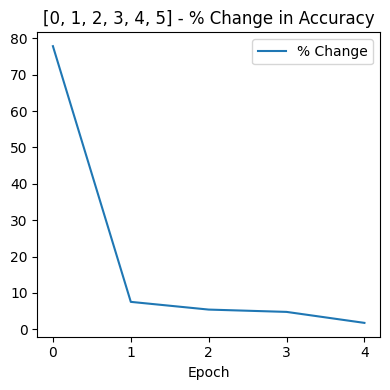

In [4]:
# Set up common configurations
train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

if args.test_reduced:
        sampled_indices = torch.randperm(len(mnist_dataset))[:1000]
        mnist_dataset = Subset(mnist_dataset, sampled_indices)

# Define task 1 labeling
task1_classes = [0, 1, 2, 3, 4, 5]
task1_indices = [i for i, (_, label) in enumerate(mnist_dataset) if label in task1_classes]
task1_dataset = Subset(mnist_dataset, task1_indices)

train_size_task1 = int(0.8 * len(task1_indices))
test_size_task1 = len(task1_indices) - train_size_task1

train_loader_task1, test_loader_task1 = get_data_loaders(task1_dataset, train_size_task1, test_size_task1,
                                                             train_kwargs, test_kwargs)
model = models.Net_log_softmax(classes = len(task1_classes)).to(device)
#model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
train_and_validate(args, model, device, train_loader_task1, test_loader_task1, optimizer, scheduler,title=f"Task 1 with labels {task1_classes}",type_label= task1_classes)
model_state_dict_task1 = model.state_dict()
save_model_state_dict(model_state_dict_task1, "mnist_cnn_task1.pt")


In [5]:
validate(model, device, test_loader_task1)

\Val set: Average loss: 0.1737, Accuracy: 115/120 (96%)



(95.83333333333333,
 0.17373943328857422,
 array([1, 4, 1, 1, 3, 5, 1, 2, 3, 2, 3, 5, 5, 5, 0, 4, 1, 0, 1, 0, 0, 2,
        0, 4, 1, 3, 0, 1, 4, 0, 5, 1, 5, 2, 1, 2, 2, 3, 5, 1, 5, 5, 1, 0,
        5, 4, 2, 1, 1, 0, 3, 5, 5, 3, 1, 0, 4, 4, 2, 4, 0, 1, 4, 4, 4, 2,
        3, 5, 1, 4, 1, 2, 0, 2, 1, 2, 1, 3, 4, 1, 0, 1, 0, 2, 4, 1, 0, 2,
        1, 1, 4, 2, 1, 4, 3, 4, 2, 3, 4, 0, 0, 5, 3, 4, 2, 3, 2, 0, 4, 1,
        5, 3, 4, 0, 2, 2, 1, 5, 3, 5]),
 array([1, 4, 1, 1, 3, 5, 1, 2, 3, 2, 3, 5, 5, 5, 0, 4, 1, 0, 1, 0, 0, 2,
        0, 4, 1, 3, 2, 2, 4, 0, 5, 1, 5, 2, 1, 2, 2, 3, 5, 1, 5, 5, 5, 0,
        5, 4, 2, 1, 1, 0, 3, 5, 5, 3, 1, 0, 4, 4, 2, 4, 0, 1, 4, 4, 4, 2,
        3, 5, 1, 4, 1, 2, 0, 2, 1, 2, 1, 3, 4, 1, 0, 1, 5, 2, 4, 1, 0, 2,
        1, 1, 4, 2, 1, 4, 3, 4, 2, 3, 4, 0, 0, 5, 3, 4, 2, 3, 2, 3, 4, 1,
        5, 3, 4, 0, 2, 2, 1, 5, 3, 5]))

# Testing on 4 different tasks 


8 1
Train Epoch: 1 [0/479 (0%)]	Loss: 6.030193
\Val set: Average loss: 0.9223, Accuracy: 83/120 (69%)

Epoch 1/5: Training Loss: 0.0331, Val Accuracy: 69.17%
Train Epoch: 2 [0/479 (0%)]	Loss: 0.963310
\Val set: Average loss: 0.5956, Accuracy: 98/120 (82%)

Epoch 2/5: Training Loss: 0.0114, Val Accuracy: 81.67%
Train Epoch: 3 [0/479 (0%)]	Loss: 0.581516
\Val set: Average loss: 0.5074, Accuracy: 103/120 (86%)

Epoch 3/5: Training Loss: 0.0080, Val Accuracy: 85.83%
Train Epoch: 4 [0/479 (0%)]	Loss: 0.317503
\Val set: Average loss: 0.4413, Accuracy: 106/120 (88%)

Epoch 4/5: Training Loss: 0.0059, Val Accuracy: 88.33%
Train Epoch: 5 [0/479 (0%)]	Loss: 0.293323
\Val set: Average loss: 0.4103, Accuracy: 105/120 (88%)

Epoch 5/5: Training Loss: 0.0047, Val Accuracy: 87.50%
Best validation loss: 0.4103 at epoch 6
Model state dict saved to: models/mnist_cnn_task 2 with labels [8, 9, 1, 2, 3, 4].pt
8 1
Train Epoch: 1 [0/485 (0%)]	Loss: 5.428768
\Val set: Average loss: 1.5941, Accuracy: 29/122 (2

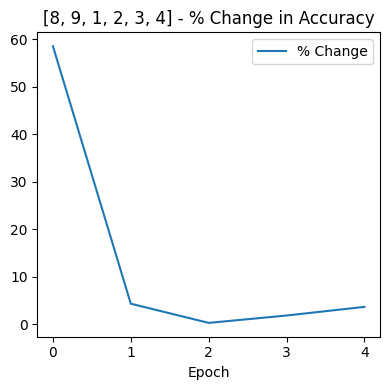

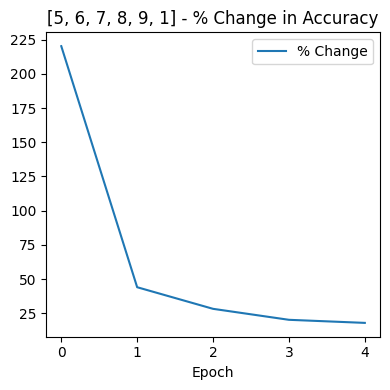

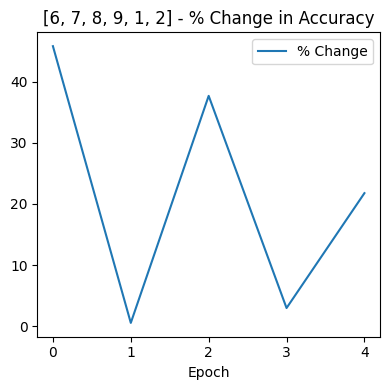

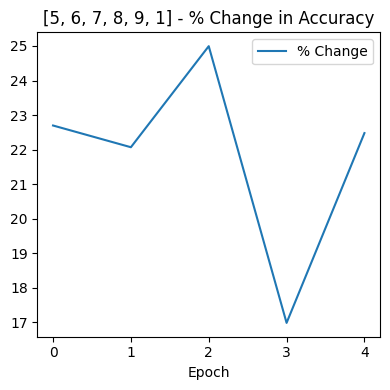

In [6]:
model_taskN = models.Net_log_softmax(classes=len(task1_classes)).to(device)

model_state_dict_task1 = torch.load("models/mnist_cnn_task1.pt")
model_taskN.load_state_dict(model_state_dict_task1.copy())
optimizer_taskN = optim.Adadelta(model_taskN.parameters(), lr=args.lr)
scheduler_taskN = StepLR(optimizer_taskN, step_size=1, gamma=args.gamma)

for i in range(4):
    # Get scenario labels for each iteration
    scenario_labels_i = get_scenario_labels()
    run_scenario(args,optimizer_taskN,scheduler_taskN, model_taskN, device, train_kwargs, test_kwargs, scenario_labels_i, transform=transform, title_prefix=f"Task 2 with labels {scenario_labels_i}")
